# Import Libraries

In [5]:
import pandas as pd
from transformers import (AutoModelForSequenceClassification, TFAutoModelForSequenceClassification,
                          AutoTokenizer, pipeline, TFAutoModel, AutoTokenizer)
import numpy as np
from scipy.special import softmax
import tensorflow as tf
import torch
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Lambda, GRU
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.models import Model
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [6]:
df = pd.read_csv('/content/amazon_reviews.csv')

# Pelabelan menggunakan model Roberta

In [7]:
def content_labels(contents, model_name='cardiffnlp/twitter-xlm-roberta-base-sentiment'):

     sentiment_analyzer = pipeline('sentiment-analysis',
                                   model=model_name,
                                   tokenizer=model_name)

     texts = contents.dropna().tolist()
     results = []
     for text in tqdm(texts, desc='Analyzing Sentiment Using XLM Roberta Model'):
         try:
             result = sentiment_analyzer(text[:512])[0]
             results.append(result['label'].lower())  # output: 'positive', 'neutral', 'negative'
         except Exception as e:
             print(f'Error processing content: {text}. Error: {e}')

     return pd.DataFrame({
         'content': texts,
         'label': results
     })

In [8]:
labeled_contents = content_labels(df['content'])

Device set to use cuda:0
Analyzing Sentiment Using XLM Roberta Model: 100%|██████████| 29996/29996 [05:03<00:00, 98.87it/s] 


In [9]:
labeled_contents.label.value_counts()

,count
label,
negative,15392
positive,11421
neutral,3183


# Preprocessing

## cleaning text

In [10]:
df = labeled_contents.copy()
df = labeled_contents.drop_duplicates(subset='content', keep='first')
df = labeled_contents.dropna(subset=['content'])

def clean_review(text):
    text = str(text)
    text = re.sub(r'<.*?>', '', text)  # menghapus HTML tags
    text = re.sub(r'http\S+|www.\S+', '', text)  # menghapus URLs
    text = re.sub(r'[^A-Za-z0-9\s.,!?\'\"]+', '', text)  # mengahapus non-ASCII chars dan emojis
    text = re.sub(r'\s+', ' ', text).strip()  # menghapus spasi berlebih
    return text

df['cleaned_review'] = df['content'].apply(clean_review)

## encode label

In [11]:
encode = LabelEncoder()
df['label_score'] = encode.fit_transform(df['label'])

# Skema 1

* menggunakan tokenizer dari model pretrain `distilbert-base-uncased`
* embedding menggunakan tensorflow
* menangani imbalance class
* model LSTM
* optimizer Adam

In [12]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
encodings = tokenizer(
    list(df["cleaned_review"]),
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors="np"  # agar bisa di splitting dgn train test split
)

input_ids = encodings["input_ids"]
attention_mask = encodings["attention_mask"]
labels = df["label_score"].values

# split data
X_ids_train_distilbert, X_ids_test_distilbert, X_mask_train_distilbert, X_mask_test_distilbert, y_train_distilbert, y_test_distilbert = train_test_split(
    input_ids, attention_mask, labels, test_size=0.2, stratify=labels
)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [13]:
# buat tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(({
                    'input_ids': X_ids_train_distilbert,
                    'attention_mask': X_mask_train_distilbert
                }, y_train_distilbert)).batch(32)

val_dataset = tf.data.Dataset.from_tensor_slices(({
                  'input_ids': X_ids_test_distilbert,
                  'attention_mask': X_mask_test_distilbert
              }, y_test_distilbert)).batch(32)

In [14]:
# parameter
vocab_size = tokenizer.vocab_size
max_length = X_ids_train_distilbert.shape[1]
embedding_dim = 128

In [15]:
# compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_distilbert),
    y=y_train_distilbert
)

# convert class weights menjadi dictionary
class_weight_dict = dict(enumerate(class_weights))

In [16]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [17]:
# model
input_ids = Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
x = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_ids)
x = LSTM(64)(x)
x = Dense(32, activation='relu')(x)
output = Dense(3, activation='softmax')(x)

model = Model(inputs=input_ids, outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# training dengan validasi
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_ids
Received: inputs=['Tensor(shape=(None, 128))']
  warnings.warn(msg)


750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.3532 - loss: 1.0989 - val_accuracy: 0.6350 - val_loss: 0.9490
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7316 - loss: 0.8461 - val_accuracy: 0.7385 - val_loss: 0.6198
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7896 - loss: 0.5671 - val_accuracy: 0.8112 - val_loss: 0.4825
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8556 - loss: 0.3998 - val_accuracy: 0.8227 - val_loss: 0.4782
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8926 - loss: 0.3131 - val_accuracy: 0.8298 - val_loss: 0.4731
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9131 - loss: 0.2596 - val_accuracy: 0.8395 - val_loss: 0.4716
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9298 - loss: 0.2077 - val_accuracy: 0.8408 - val_loss: 0.4637
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9401 - loss: 0.1679 - val_accu

In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)               │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 128, 128)            │       3,906,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,875,211 (45.30 MB)

 Trainable params: 3,958,403 (15.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,916,808 (30.20 MB)

## Evaluasi Skema 1

In [19]:
y_pred_probs = model.predict(X_ids_test_distilbert)

# convert menjadi label
y_pred = np.argmax(y_pred_probs, axis=1)
print(classification_report(y_test_distilbert, y_pred))

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      3079
           1       0.49      0.64      0.55       637
           2       0.93      0.87      0.90      2284

    accuracy                           0.86      6000
   macro avg       0.78      0.80      0.79      6000
weighted avg       0.87      0.86      0.87      6000



In [20]:
print(round(accuracy_score(y_test_distilbert, y_pred), 4))

0.8603


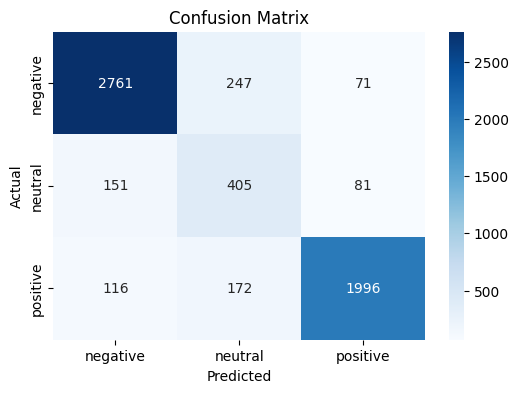

In [21]:
cm = confusion_matrix(y_test_distilbert, y_pred)
labels = ['negative', 'neutral', 'positive']  # sesuaikan dengan urutan label

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## Inference Skema 1

In [26]:
reviews = [
    "Amazon app is amazing and quick.",
    "It crashes often and is really annoying.",
    "The UI is bad",
    "it's fine",
    " all seems fine"
]

batch_encoding = tokenizer(
    reviews,
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors="tf"
)

predictions = model.predict({
                  'input_ids': batch_encoding['input_ids'],
                  'attention_mask': batch_encoding['attention_mask']
              })

predicted_labels = tf.argmax(predictions, axis=1).numpy()
for review, label in zip(reviews, predicted_labels):
    print(f"Review: {review}\nSentiment: {encode.inverse_transform([label])[0]}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Review: Amazon app is amazing and quick.
Sentiment: positive

Review: It crashes often and is really annoying.
Sentiment: negative

Review: The UI is bad
Sentiment: negative

Review: it's fine
Sentiment: neutral

Review:  all seems fine
Sentiment: neutral



# Skema 2

* menggunakan tokenizer dari model pretrain `distilbert-base-uncased`
* menggunakan DistilBERT sebagai Feature Extractor (tanpa fine-tuning), ambil output [batch_size, seq_len, hidden_size] dari BERT untuk embedding
* handling imbalance class
* model LSTM
* optimizer Adam

In [27]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
bert_model = TFAutoModel.from_pretrained("distilbert-base-uncased")
bert_model.trainable = False  # freeze weight karena hanya ingin pakai embedding

encodings = tokenizer(
    list(df['cleaned_review']),
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors='np'
)

input_ids = encodings['input_ids']
attention_mask = encodings['attention_mask']
labels = df['label_score'].values

# split data
X_ids_train, X_ids_test, X_mask_train, X_mask_test, y_train, y_test = train_test_split(
    input_ids, attention_mask, labels, test_size=0.2, stratify=labels
)


# buat tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(({
                    'input_ids': X_ids_train,
                    'attention_mask': X_mask_train
                }, y_train)).batch(32)

val_dataset = tf.data.Dataset.from_tensor_slices(({
                  'input_ids': X_ids_test,
                  'attention_mask': X_mask_test
              }, y_test)).batch(32)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [28]:
# input
input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(128,), dtype=tf.int32, name='attention_mask')

# mendapatkan embeddings BERT menggunakan Lambda layer
# memberikan output shape untuk Lambda layer, 128 -> max_length saat tokenisasi, 768 -> hidden size distilbert-base-uncased
bert_outputs = Lambda(lambda x: bert_model(x, training=False).last_hidden_state,
                     output_shape=(128, 768))({'input_ids': input_ids, 'attention_mask': attention_mask})
sequence_output = bert_outputs  # (batch_size, seq_len, hidden_size)

# model
x = LSTM(64)(sequence_output)  # belajar dari urutan token
x = Dense(32, activation='relu')(x)
output = Dense(3, activation='softmax')(x)

model2 = Model(inputs=[input_ids, attention_mask], outputs=output)
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ attention_mask            │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_ids (InputLayer)    │ (None, 128)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 128, 768)       │              0 │ attention_mask[0][0],  │
│                           │                        │                │ input_ids[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 64)             │        213,248 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 32)             │          2,080 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 3)              │             99 │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 215,427 (841.51 KB)

 Trainable params: 215,427 (841.51 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
history = model2.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 139s 175ms/step - accuracy: 0.7794 - loss: 0.5740 - val_accuracy: 0.8248 - val_loss: 0.4310
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 143s 177ms/step - accuracy: 0.8372 - loss: 0.4167 - val_accuracy: 0.8300 - val_loss: 0.4285
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 134s 179ms/step - accuracy: 0.8490 - loss: 0.3773 - val_accuracy: 0.8408 - val_loss: 0.3760
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 135s 179ms/step - accuracy: 0.8607 - loss: 0.3389 - val_accuracy: 0.8447 - val_loss: 0.3658
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 149s 199ms/step - accuracy: 0.8734 - loss: 0.3042 - val_accuracy: 0.8493 - val_loss: 0.3502
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 185s 176ms/step - accuracy: 0.8841 - loss: 0.2690 - val_accuracy: 0.8510 - val_loss: 0.3560
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 134s 179ms/step - accuracy: 0.8957 - loss: 0.2376 - val_accuracy: 0.8490 - val_loss: 0.3802
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 142s 179ms/step - accuracy: 0.9031 -

## Evaluasi Skema 2

In [30]:
y_pred_probs2 = model2.predict({
                  'input_ids': X_ids_test,
                  'attention_mask': X_mask_test
              })

# convert menjadi label
y_pred2 = np.argmax(y_pred_probs2, axis=1)
print(classification_report(y_test, y_pred2))

188/188 ━━━━━━━━━━━━━━━━━━━━ 28s 146ms/step
              precision    recall  f1-score   support

           0       0.97      0.84      0.90      3079
           1       0.47      0.83      0.60       637
           2       0.92      0.88      0.90      2284

    accuracy                           0.86      6000
   macro avg       0.79      0.85      0.80      6000
weighted avg       0.90      0.86      0.87      6000



In [33]:
print(round(accuracy_score(y_test, y_pred2), 4))

0.8567


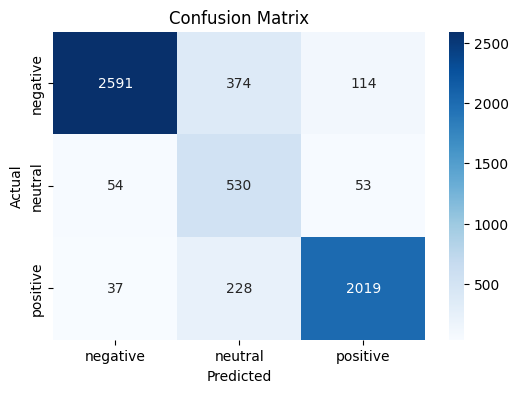

In [32]:
cm = confusion_matrix(y_test, y_pred2)
labels = ['negative', 'neutral', 'positive']  # sesuaikan dengan urutan label

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## Inference Skema 2

In [34]:
reviews = [
    "Amazon app is amazing and quick.",
    "It crashes often and is really annoying.",
    "The UI is bad",
    "it's fine",
    "   haven't tried further to buy furnitures"
]

batch_encoding = tokenizer(
    reviews,
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors="tf"
)

predictions = model2.predict({
                  'input_ids': batch_encoding['input_ids'],
                  'attention_mask': batch_encoding['attention_mask']
              })

predicted_labels = tf.argmax(predictions, axis=1).numpy()
for review, label in zip(reviews, predicted_labels):
    print(f"Review: {review}\nSentiment: {encode.inverse_transform([label])[0]}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step
Review: Amazon app is amazing and quick.
Sentiment: positive

Review: It crashes often and is really annoying.
Sentiment: negative

Review: The UI is bad
Sentiment: negative

Review: it's fine
Sentiment: neutral

Review:    haven't tried further to buy furnitures
Sentiment: neutral



# Skema 3:

* menggunakan tokenizer dari model pretrain `distilbert-base-uncased`
* menggunakan DistilBERT sebagai Feature Extractor (tanpa fine-tuning), ambil output [batch_size, seq_len, hidden_size] dari BERT untuk embedding
* handling imbalance class
* model GRU
* optimizer Adam


(beberapa part sama dengan skema 2, jadi langsung modeling)

In [35]:
# input
input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(128,), dtype=tf.int32, name='attention_mask')

# mendapatkan embeddings BERT menggunakan Lambda layer
# memberikan output shape untuk Lambda layer, 128 -> max_length saat tokenisasi, 768 -> hidden size distilbert-base-uncased
bert_outputs = Lambda(lambda x: bert_model(x, training=False).last_hidden_state,
                     output_shape=(128, 768))({'input_ids': input_ids, 'attention_mask': attention_mask})
sequence_output = bert_outputs  # (batch_size, seq_len, hidden_size)

# model
x = GRU(64)(sequence_output)  # belajar dari urutan token
x = Dense(32, activation='relu')(x)
output = Dense(3, activation='softmax')(x)

model3 = Model(inputs=[input_ids, attention_mask], outputs=output)
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model3.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ attention_mask            │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_ids (InputLayer)    │ (None, 128)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 128, 768)       │              0 │ attention_mask[0][0],  │
│                           │                        │                │ input_ids[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru (GRU)                 │ (None, 64)             │        160,128 │ lambda_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 32)             │          2,080 │ gru[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 3)              │             99 │ dense_4[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 162,307 (634.01 KB)

 Trainable params: 162,307 (634.01 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
history = model3.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 156s 200ms/step - accuracy: 0.7830 - loss: 0.5592 - val_accuracy: 0.8253 - val_loss: 0.3962
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 184s 175ms/step - accuracy: 0.8488 - loss: 0.3793 - val_accuracy: 0.8248 - val_loss: 0.4008
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 158s 197ms/step - accuracy: 0.8642 - loss: 0.3357 - val_accuracy: 0.8335 - val_loss: 0.3859
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 185s 175ms/step - accuracy: 0.8796 - loss: 0.2945 - val_accuracy: 0.8475 - val_loss: 0.3608
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 133s 178ms/step - accuracy: 0.8931 - loss: 0.2563 - val_accuracy: 0.8645 - val_loss: 0.3392
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 142s 178ms/step - accuracy: 0.9087 - loss: 0.2194 - val_accuracy: 0.8680 - val_loss: 0.3494
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 134s 179ms/step - accuracy: 0.9155 - loss: 0.2011 - val_accuracy: 0.8853 - val_loss: 0.3074
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 142s 179ms/step - accuracy: 0.9200 -

## Evaluasi Skema 3

In [37]:
y_pred_probs3 = model3.predict({
                  'input_ids': X_ids_test,
                  'attention_mask': X_mask_test
              })

# convert menjadi label
y_pred3 = np.argmax(y_pred_probs3, axis=1)
print(classification_report(y_test, y_pred3))

188/188 ━━━━━━━━━━━━━━━━━━━━ 28s 145ms/step
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      3079
           1       0.57      0.75      0.65       637
           2       0.94      0.89      0.91      2284

    accuracy                           0.89      6000
   macro avg       0.82      0.85      0.83      6000
weighted avg       0.90      0.89      0.89      6000



In [38]:
print(round(accuracy_score(y_test, y_pred3), 4))

0.8853


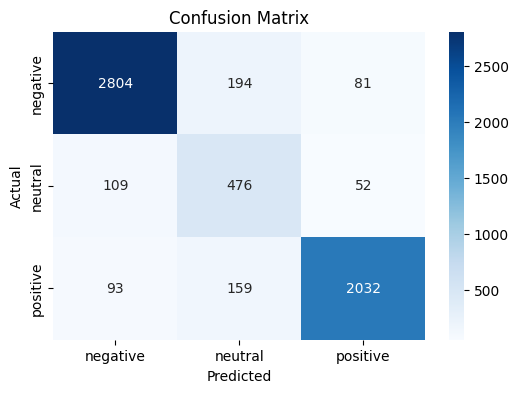

In [39]:
cm = confusion_matrix(y_test, y_pred3)
labels = ['negative', 'neutral', 'positive']  # sesuaikan dengan urutan label

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Inference Skema 3

In [43]:
reviews = [
    "Their delivery speed? Chef’s kiss, goodly unexpected 👌🔥",
    "It crashes often and is really annoying.",
    " they really need to check the system — my item’s lost and refund takes forever. ",
    "   haven't tried further to buy furnitures",
    "i dont know about some features, it's suck.",
    "yeah the UI ...",
    "When are they going to add customize mode like dark mode?",
    "Honestly, it just works. No complaints here 👌",
    "it’s fine ..., does what it’s supposed to",
    "notifications are outta control, chill please"
]

batch_encoding = tokenizer(
    reviews,
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors="tf"
)

predictions = model3.predict({
                  'input_ids': batch_encoding['input_ids'],
                  'attention_mask': batch_encoding['attention_mask']
              })

predicted_labels = tf.argmax(predictions, axis=1).numpy()
for review, label in zip(reviews, predicted_labels):
    print(f"Review: {review}\nSentiment: {encode.inverse_transform([label])[0]}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Review: Their delivery speed? Chef’s kiss, goodly unexpected 👌🔥
Sentiment: positive

Review: It crashes often and is really annoying.
Sentiment: negative

Review:  they really need to check the system — my item’s lost and refund takes forever. 
Sentiment: negative

Review:    haven't tried further to buy furnitures
Sentiment: neutral

Review: i dont know about some features, it's suck.
Sentiment: negative

Review: yeah the UI ...
Sentiment: neutral

Review: When are they going to add customize mode like dark mode?
Sentiment: neutral

Review: Honestly, it just works. No complaints here 👌
Sentiment: neutral

Review: it’s fine ..., does what it’s supposed to
Sentiment: positive

Review: notifications are outta control, chill please
Sentiment: negative

